# Conifer Synthesis with 5 Classifier GradientBoost BDT on ATLAS Jet Data

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics
import conifer
import datetime
import numpy as np
import matplotlib.pyplot as plt
import itertools

### Fetch jet data

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Print out subet of data

In [3]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
[[-2.93512535e+00  3.83155316e-01  5.12587558e-03  8.42466834e-05
   9.06995591e-03  1.78931368e-04  1.76944518e+00  2.12389827e+00
   1.76944518e+00  3.08185428e-01  1.35686919e-01  8.32780078e-02
   4.12136108e-01  2.99057871e-01  8.92688179e+00  7.50000000e+01]
 [-1.92733514e+00  2.70698756e-01  1.58540264e-03  1.13709866e-05
   3.23237223e-03  2.91449633e-05  2.03883362e+00  2.56309891e+00
   2.03883362e+00  2.11886495e-01  6.37285784e-02  3.63104008e-02
   3.10216516e-01  2.26661310e-01  3.88651156e+00  3.10000000e+01]
 [-3.11214662e+00  4.58171129e-01  9.79138538e-02  2.85884105e-02
   1.24277540e-01  3.84868123e-02  1.26925385e+00  1.34623826e+00
   1.26925385e+00  2.46488109e-01  1.15635969e-01  7.90941268e-02
   3.57558519e-01  2.8

### Split data into test/train subsets

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])
print(le.inverse_transform(y[:5]))

[0 3 2 4 3]
['g' 'w' 't' 'z' 'w']


### Create GradientBoostingClassifier model with 100 trees of depth 4

In [5]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
    max_depth=4, random_state=0).fit(X_train_val, y_train_val)

### Determine model accuracy

In [6]:
from sklearn.metrics import accuracy_score
y_predict = clf.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_predict)))

Accuracy: 0.6930903614457832


### Determine AUCs and ROC curves for GradientBoostingClassifier

In [7]:
def get_auc_roc(y_test, y_model):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:,i], y_model[:,i])
        roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
        
    return tpr, fpr, roc_auc

In [8]:
y_sklearn = clf.decision_function(X_test)
y_test_bin = sklearn.preprocessing.label_binarize(y_test, classes=le.transform(list(le.classes_)))
tpr, fpr, roc_auc = get_auc_roc(y_test_bin, y_sklearn)

### Plot ROC Curve as Signal Efficiency vs Log of Background Efficiency

In [9]:
# Plot all ROC curves
def make_ROC(le, tpr, fpr, roc_auc, ax, line_style, class_label):
    lw=2
    n_classes=len(list(le.classes_))

    from itertools import cycle
    # Add more colors if you have more than 5 classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(tpr[i], fpr[i], line_style, color=color, lw=lw,
                 label= list(le.classes_)[i] + ' ' + class_label + ' (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    return ax

In [10]:
def plot_ROC(ax):
    ax.semilogy()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([10e-4, 1.0])
    ax.set_xlabel('Signal Efficiency')
    ax.set_ylabel('Background Efficiency')
    ax.legend(loc="upper left")

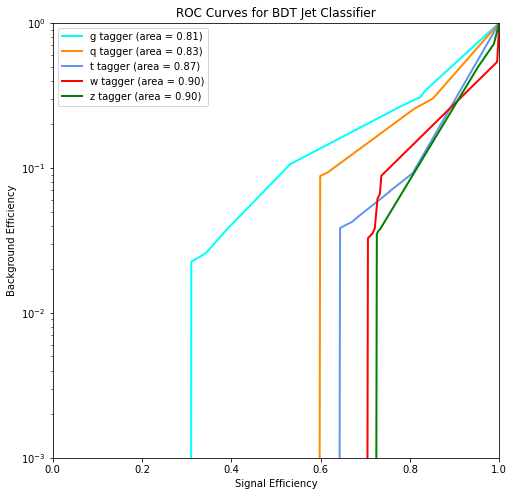

In [11]:
sklearn_fig = plt.figure(figsize=[8,8])
sklearn_ax = sklearn_fig.add_subplot()
sklearn_ax.set_title('ROC Curves for BDT Jet Classifier')

sklearn_ax = make_ROC(le, tpr, fpr, roc_auc, sklearn_ax, '-', 'tagger')
plot_ROC(sklearn_ax)

### Generate confusion matrix

In [12]:
cm = sklearn.metrics.confusion_matrix(y_test, y_predict, labels=le.transform(list(le.classes_)))

In [13]:
# confusion matrix code from Maurizio
# /eos/user/m/mpierini/DeepLearning/ML4FPGA/jupyter/HbbTagger_Conv1D.ipynb
def plot_confusion_matrix(cm, classes,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    cbar = plt.colorbar()
    plt.clim(0,1)
    cbar.set_label(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

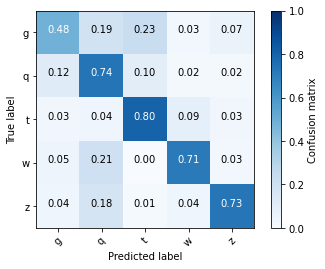

In [14]:
plot_confusion_matrix(cm,list(le.classes_), normalize=True)

### Perform model synthesis

In [15]:
# Create a conifer config
cfg = conifer.backends.vivadohls.auto_config()

# Set the output directory to something unique
cfg['OutputDir'] = 'tauTrees/prj_{}'.format(int(datetime.datetime.now().timestamp()))

# Create and compile the model
model = conifer.model(clf, conifer.converters.sklearn, conifer.backends.vivadohls, cfg)
model.compile()

# Run HLS C Simulation and get the output
y_conif = model.decision_function(X_test)

# Synthesize the model
model.build()

### Generate Resource Reports

In [16]:
import hls4ml
hls4ml.report.read_vivado_report(cfg['OutputDir'])

Found 1 solution(s) in tauTrees/prj_1605075846/my_prj_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'my_prj'
* Date:           Wed Nov 11 00:24:44 2020

* Version:        2018.2 (Build 2258646 on Thu Jun 14 20:25:20 MDT 2018)
* Project:        my_prj_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcvu9p-flgb2104-2L-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     2.667|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |    4|    4|    5|    5| function |
    +-----+-----+-----+-----+--------

### Generate ROC curve metrics for conifer model

In [17]:
tpr_conif, fpr_conif, roc_auc_conif = get_auc_roc(y_test_bin, y_conif)

### Plot ROC curves comparing sklearn model to conifer model

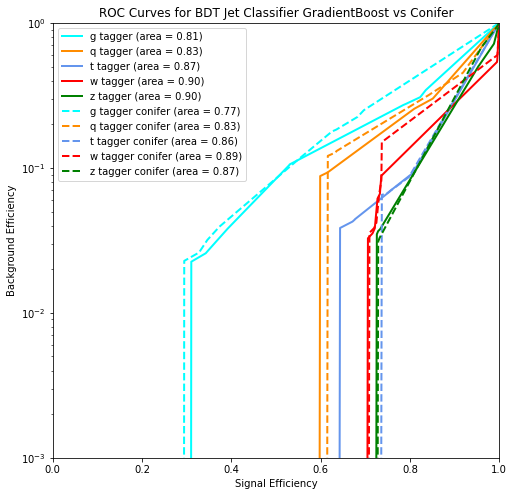

In [18]:
conif_sklearn_fig = plt.figure(figsize=[8,8])
conif_sklearn_ax = conif_sklearn_fig.add_subplot()
conif_sklearn_ax.set_title('ROC Curves for BDT Jet Classifier GradientBoost vs Conifer')

conif_sklearn_ax = make_ROC(le, tpr, fpr, roc_auc, conif_sklearn_ax, '-', 'tagger')
conif_sklearn_ax = make_ROC(le, tpr_conif, fpr_conif, roc_auc_conif, conif_sklearn_ax, '--', 'tagger conifer')
plot_ROC(conif_sklearn_ax)